In [2]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

# 경고 뜨지 않게...
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False
# 매직명령어 => 쥬피터노트북에서 그래프 삽입 기능 
%matplotlib inline
# 글꼴 선명화 
%config InlineBackend.figure_format = 'retina'

# 랜덤 모듈
import random

# 학습 모델 저장 및 복원
import pickle

# 딥러닝 라이브러리
import tensorflow as tf
# 신경망 모델을 관리하는 객체
from tensorflow.keras.models import Sequential
# 선형 회귀 레이어
from tensorflow.keras.layers import Dense
# 활성화 함수를 정의하는 객체
from tensorflow.keras.layers import Activation

# CNN : 커널을 통해 합성곱을 구하는 것. 이미지의 특징이 두드러 지게 한다.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D

# MaxPooling : 커널내에서 가장 큰 값을 추출하는 방식으로 불필요한 부분을 제거한다.
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPool1D

# 1차원으로 변환하는 것
from tensorflow.keras.layers import Flatten

# Dropout : 이미자나 영상, 음파 등의 데이터는 오랫동안 학습을 진행 시켜야 한다.
# 하지만 너무 빨리 과적합이 발생되면 조기 중단 때문에 학습 횟수가 줄어들 수 있다.
# 이에 은닉의 노드를 일부 사용하지 않으므로써 과적합이 빨리 오는 것을 예방하고
# 오랫동안 학습이 가능하다.
from tensorflow.keras.layers import Dropout

# Embadding : 단어의 수를 조정한다.
from tensorflow.keras.layers import Embedding

# RNN(LSTM)
from tensorflow.keras.layers import LSTM

# GAN
# 데이터 표준화
from tensorflow.keras.layers import BatchNormalization
# 데이터를 다시 구성하기 위한 것
from tensorflow.keras.layers import Reshape
# 업샘플링
from tensorflow.keras.layers import UpSampling2D
# 이미지 생성을 위해 사용할 데이터 공간을 생성
from tensorflow.keras.layers import Input
# 다수의 신경망을 연결하기 위한 것(생성자와 판별자를 연결)
from tensorflow.keras.models import Model

# 원핫 인코딩을 수행하는 함수
from tensorflow.keras.utils import to_categorical

# 저장된 학습모델을 복원한다.
from tensorflow.keras.models import load_model

# 모델을 자동 저장한다.
from tensorflow.keras.callbacks import ModelCheckpoint
# 성능이 더이상 좋아지지 않을 경우 중단 시킨다.
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# 문장을 잘라준다.
from tensorflow.keras.preprocessing.text import Tokenizer
# 모든 문장 데이터의 단어 데이터의 수를 동일한 수로 맞춰준다.
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 문자열을 가지고 단어 사전을 만들어준다.
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 표준화
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# 문자열 => 숫자
from sklearn.preprocessing import LabelEncoder

# 전체데이터를 학습용과 검증으로 나눈다.
from sklearn.model_selection import train_test_split

# 랜덤시드 설정
# 데이터를 랜덤하게 섞거나 가중치를 랜덤하게 설정하는 등..
# 작업에서 랜덤을 적용하는 경우가 더러 있다.
# 이에, 시드를 고정시킨다.
random_seed = 1
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

# 현재 프로젝트에서 GPU 메모리 사용을 필요한 만큼만 쓸 수 있도록 한다.
# 컴퓨터에 있는 GPU 정보들을 가져온다.

gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu가 있다면...
if len(gpus) > 0 :
    try :
        for gpu in gpus :
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e :
        print(e)

### Auto Encoder
- 인코더와 디코더가 있다
- 인코더는 입력데이터인 이미지의 특성을 추출하는 역할을 한다.
- 디코더는 인코더가 추출한 이미지 특성을 기반으로 이미지를 복원한다.
- 이미지 복원 작업에서 주로 쓰여지며 이미지의 노이즈 등을 제거할 대 사용한다.

In [3]:
# MNIST
from tensorflow.keras.datasets import mnist

In [4]:
(X_train, _), (X_test, _) = mnist.load_data()

In [5]:
# 데이터 표준화 작업
# 이미지 개수, 세로, 가로 형태의 행렬을
# 이미지 개수, 세로, 가로, 채널 형태로 변환한다.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float64')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float64')

# 오토 인코더는 마지막 활성함수를 sigmoid를 쓰기 때문에
# 표준화는 0~1사이로 맞춘다.
X_train = X_train / 255
X_test = X_test / 255

In [6]:
# 학습 모델 생성
model = Sequential()

In [7]:
# 인코딩
model.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Conv2D(8, kernel_size=3, padding='same'))
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Conv2D(8, kernel_size=3, padding='same'))
model.add(Activation('relu'))

In [8]:
# 디코딩
model.add(Conv2D(8, kernel_size=3, padding='same'))
model.add(Activation('relu'))

model.add(UpSampling2D())

model.add(Conv2D(8, kernel_size=3, padding='same'))
model.add(Activation('relu'))

model.add(UpSampling2D())

model.add(Conv2D(16, kernel_size=3, padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(1, kernel_size=3, padding='same'))
model.add(Activation('sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 activation (Activation)     (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 8)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                    

In [10]:
# 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam')

In [11]:
model.fit(X_train, X_train, validation_data=[X_test, X_test], epochs=50, batch_size=100)

Epoch 1/50
600/600 [==============================] - 6s 6ms/step - loss: 0.1502 - val_loss: 0.0884
Epoch 2/50
600/600 [==============================] - 3s 6ms/step - loss: 0.0845 - val_loss: 0.0802
Epoch 3/50
600/600 [==============================] - 3s 6ms/step - loss: 0.0796 - val_loss: 0.0775
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 0.0774 - val_loss: 0.0757
Epoch 5/50
600/600 [==============================] - 3s 6ms/step - loss: 0.0760 - val_loss: 0.0748
Epoch 6/50
600/600 [==============================] - 3s 6ms/step - loss: 0.0749 - val_loss: 0.0737
Epoch 7/50
600/600 [==============================] - 3s 6ms/step - loss: 0.0740 - val_loss: 0.0731
Epoch 8/50
600/600 [==============================] - 3s 6ms/step - loss: 0.0733 - val_loss: 0.0722
Epoch 9/50
600/600 [==============================] - 3s 6ms/step - loss: 0.0726 - val_loss: 0.0716
Epoch 10/50
600/600 [==============================] - 3s 6ms/step - loss: 0.0722 - val_loss: 0.0713

In [12]:
# 랜덤하게 5개의 이미지를 추출한다.
ae_img = model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


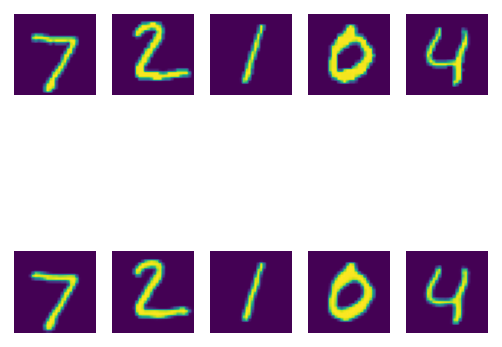

In [16]:
for i, image_idx in enumerate(range(5)):
    # 원본을 그린다
    ax = plt.subplot(2, 7, i+1)
    plt.imshow(X_test[image_idx].reshape(28,28))
    ax.axis('off')
    
    # 예측 이미지
    ax = plt.subplot(2, 7, 7+i+1)
    plt.imshow(ae_img[image_idx].reshape(28, 28))
    ax.axis('off')
    
plt.show()